# Mobile Brand

We will start with filling the brand column first as it has the least number of missing values in the data set. 

## Imports

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle

%matplotlib inline
pd.options.mode.chained_assignment = None

## Loading the data sets

In [2]:
mobile = pd.read_csv('mobile_data_info_train_competition.csv')
tags = pd.read_csv('tags.csv')

In [3]:
mobile_brand = mobile[['itemid', 'title', 'Brand']]
mobile_brand.head()

,itemid,title,Brand
0,2346660,apple iphone 4s back glass spare part original...,2.0
1,2816338,iphone 4s 64gb white,2.0
2,2847602,samsung sm b310e piton dual sim,43.0
3,3116949,samsung caramel gt e1272 dual sim 32 mb putih,43.0
4,3794648,garskin sony experia z z1 z2 ultra,38.0


In [4]:
mobile_brand.isnull().sum()

itemid       0
title        0
Brand     5292
dtype: int64

In [5]:
tags_brand = tags[['brand', 'brand_val']].dropna()
tags_brand

,brand,brand_val
0,google,0.0
1,htc,1.0
2,apple,2.0
3,wiko,3.0
4,polytron,4.0
5,huawei,21.0
6,gionee,5.0
7,leagoo,6.0
8,brandcode,7.0
9,luna,8.0


## More EDA and Cleaning

In [6]:
mobile_brand_filled = mobile_brand.dropna()

In [7]:
mobile_brand_filled['Brand'].value_counts()

43.0    33667
2.0     30398
55.0    21548
33.0    14679
46.0    11982
52.0     8042
30.0     5785
38.0     5754
29.0     2726
41.0     2607
22.0     2520
51.0     1537
13.0     1413
21.0     1186
47.0     1091
17.0      907
53.0      902
0.0       869
16.0      840
35.0      771
10.0      681
7.0       669
54.0      409
50.0      360
48.0      350
9.0       275
4.0       271
1.0       266
15.0      257
12.0      216
8.0       215
42.0      193
11.0      172
37.0      161
32.0      148
14.0      144
3.0       117
40.0      110
19.0      105
28.0       96
45.0       78
20.0       78
26.0       74
24.0       64
39.0       61
5.0        54
6.0        39
25.0       33
18.0       32
23.0       30
27.0       27
31.0       15
34.0       10
36.0        3
49.0        1
Name: Brand, dtype: int64

We will look at brands 36 and 49 as they have very few members and may be mislabelled. 

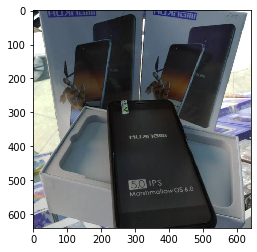

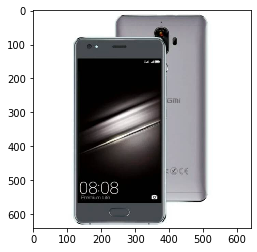

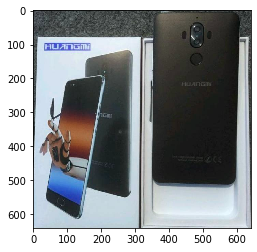

In [8]:
# looking at phones with brand 36
for img in mobile[mobile_brand['Brand'] == 36]['image_path']:
        plt.imshow(cv2.imread(img))
        plt.show()

The 3 phones are correctly labelled. Now that leaves us to check for phone brand labelled 49 (ifone). 

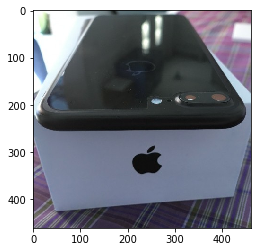

In [9]:
for img in mobile[mobile_brand['Brand'] == 49]['image_path']:
        plt.imshow(cv2.imread(img))
        plt.show()

Just from the image alone, the phone looks like it is from Apple. This suggests that this might have been mislabelled and can be tagged as 2, Apple. 

In [10]:
# we shall label the phone details accordingly before doing our train test split
mobile_brand_filled[mobile_brand_filled['Brand'] == 49]

,itemid,title,Brand
70343,463779969,ifone 7 plus 128gb,49.0


In [11]:
# labelling with correct spelling and brand
mobile_brand_filled.at[70343, 'title'] = 'iphone 7 plus 128gb'
mobile_brand_filled.at[70343, 'Brand'] = 2

In [12]:
# dropping mislabel tag
tags_brand.drop(axis=1, index=49.0, inplace=True)

In [13]:
# verifying the change
tags_brand.tail(10)

,brand,brand_val
45,doogee,45.0
46,vivo,46.0
47,evercoss,47.0
48,strawberry,48.0
50,fujitsu,50.0
51,blackberry,51.0
52,asus,52.0
53,oneplus,53.0
54,honor,54.0
55,oppo,55.0


## Feature Engineering

In [14]:
# putting the value counts into a dataframe
mobile_value_counts = {k:mobile_brand_filled['Brand'].value_counts()[k] for k in mobile_brand_filled['Brand'].value_counts().keys()}
mobile_value_counts = pd.DataFrame(mobile_value_counts.items()).rename(columns = {0:'brand_val', 1:"frequency"})
mobile_value_counts.head()

,brand_val,frequency
0,43.0,33667
1,2.0,30399
2,55.0,21548
3,33.0,14679
4,46.0,11982


In [15]:
# merging with the brands
mobile_value_counts = mobile_value_counts.merge(tags_brand, on="brand_val" )
mobile_value_counts.head()

,brand_val,frequency,brand
0,43.0,33667,samsung
1,2.0,30399,apple
2,55.0,21548,oppo
3,33.0,14679,xiaomi
4,46.0,11982,vivo


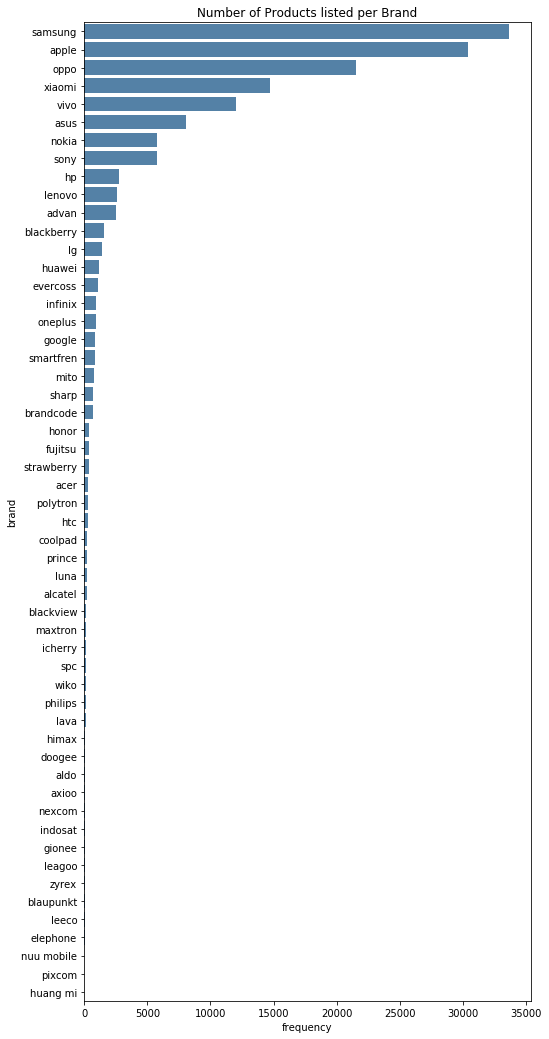

In [16]:
# visualizing the spread of the data
plt.figure(figsize=(8, 18))
ax_hist = plt.axes()
ax_hist.set_title(label ="Number of Products listed per Brand")
sns.barplot(x='frequency', y='brand', data=mobile_value_counts, orient='h', color='steelblue')

As most of the brands have too few listings, I will keep the top 19 brands and classify the rest under 'others' for a total of 20 different classes for the model. 

In [17]:
# summing up others
mobile_value_counts['frequency'][19:].sum()

6584

In [18]:
# extracting the top 19 brands
mobile_value_counts = mobile_value_counts.head(19)
mobile_value_counts

,brand_val,frequency,brand
0,43.0,33667,samsung
1,2.0,30399,apple
2,55.0,21548,oppo
3,33.0,14679,xiaomi
4,46.0,11982,vivo
5,52.0,8042,asus
6,30.0,5785,nokia
7,38.0,5754,sony
8,29.0,2726,hp
9,41.0,2607,lenovo


In [19]:
# extracting the brand_val
mobile_top19 = {mobile_value_counts.at[i, "brand_val"]:i for i in mobile_value_counts.index}
mobile_top19[100.0] = 19
mobile_top20 = mobile_top19
print(mobile_top20)

{43.0: 0, 2.0: 1, 55.0: 2, 33.0: 3, 46.0: 4, 52.0: 5, 30.0: 6, 38.0: 7, 29.0: 8, 41.0: 9, 22.0: 10, 51.0: 11, 13.0: 12, 21.0: 13, 47.0: 14, 17.0: 15, 53.0: 16, 0.0: 17, 16.0: 18, 100.0: 19}


In [20]:
# assiging the 20th class 'others'
mobile_value_counts.loc[19] = [100, 6584, 'others']

Now to do the same for the original data set, we will be looking at the filled rows to train and test our model. 

In [21]:
mobile_brand_filled

,itemid,title,Brand
0,2346660,apple iphone 4s back glass spare part original...,2.0
1,2816338,iphone 4s 64gb white,2.0
2,2847602,samsung sm b310e piton dual sim,43.0
3,3116949,samsung caramel gt e1272 dual sim 32 mb putih,43.0
4,3794648,garskin sony experia z z1 z2 ultra,38.0
...,...,...,...
160325,1510771637,beli 2 gratis 1 xiaomi mi mix black 6 64 rom g...,33.0
160326,1515822742,android i phone x real 4g 16gb free wireless c...,2.0
160327,1516747666,xiaomi mia1 ram 4gb 64gb black,33.0
160328,1517270941,khusus hari ini samsung j2 prime,43.0


In [22]:
mobile_brand_filled.rename(columns={'Brand':'brand_val'}, inplace=True)
mobile_brand_filled['new_brand_val'] = mobile_brand_filled['brand_val'].apply(lambda x : x if x in mobile_top20.keys() else 100)
mobile_brand_filled.head()

,itemid,title,brand_val,new_brand_val
0,2346660,apple iphone 4s back glass spare part original...,2.0,2.0
1,2816338,iphone 4s 64gb white,2.0,2.0
2,2847602,samsung sm b310e piton dual sim,43.0,43.0
3,3116949,samsung caramel gt e1272 dual sim 32 mb putih,43.0,43.0
4,3794648,garskin sony experia z z1 z2 ultra,38.0,38.0


In [23]:
# reassigning the brand values
mobile_brand_filled['new_brand_val'] = mobile_brand_filled['new_brand_val'].map(mobile_top20)

In [24]:
# verifying the change
mobile_brand_filled['new_brand_val'].value_counts()

0     33667
1     30399
2     21548
3     14679
4     11982
5      8042
19     6584
6      5785
7      5754
8      2726
9      2607
10     2520
11     1537
12     1413
13     1186
14     1091
15      907
16      902
17      869
18      840
Name: new_brand_val, dtype: int64

## Preprocessing

We will be doing train test split on our known data (mobile_brand_filled) to train our model.

### Using the Tfidf Vectorizer

We will be using the Tfidf Vectorizer to first vectorize our texts for the machine to process.

In [25]:
# initiating the vectorizer 
vectorizer = TfidfVectorizer(ngram_range={1,2})

In [26]:
# fitting the text to be used as features
vectorizer.fit(mobile_brand_filled['title'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range={1, 2}, norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [27]:
X = vectorizer.transform(mobile_brand_filled['title'])
y = mobile_brand_filled['new_brand_val']

In [28]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Modelling: Logistic Regression

In [29]:
# initiating the logistic model, fitting the training set and then predicting on the test set 
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred

/Users/russ1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([5, 1, 1, ..., 1, 6, 2])

In [30]:
# baseline accruacy 
lr.score(X_train, y_train)

0.991245119455099

The score on the training set has an accuracy on 99.1%.

In [31]:
# test set accuracy
lr.score(X_test, y_test)

0.9856553147574819

The score on the testing set has an accuracy of 98.6% which is not too far from the training set. 

This indicates that the model is not overfitted on the training set. 

## Misclassified Devices

We will look through the misclassified devices to see if we can identity any trends to further improve our model. 

In [32]:
mobile_mis = mobile_brand_filled.loc[y_test.index][['title', 'new_brand_val']]
mobile_mis['pred'] = list(y_pred)

In [33]:
mobile_mis[mobile_mis['new_brand_val'] != mobile_mis['pred']]['title']

160318    gratis ongkir mi max 2 series 4 64 global new ...
37042                      asuz zenfon live l1 ram 3gb 32gb
109573    promo microsd maestro16gb class10 packing berk...
49107     on salee lonwalk k108 tablet 10 inch 4g fdd lt...
5238      nomu s30 ip68 waterproof 5.5inch fhd mtk6755 2...
                                ...                        
60336                                            axio venge
13798               diskon 50 redmi 5 plus ram 4gb rom 64gb
1712                                        promo zenmax m1
22122     pple ipad mini 2 with retina display wifi cell...
111717    promo lighter splitter 2 socket with usb 5v 2....
Name: title, Length: 556, dtype: object

In [34]:
vectorizer_false = CountVectorizer(ngram_range={1,2})

In [35]:
# transforming the dataset and putting it into a dataframe, verifying the dataframe
words_false = vectorizer_false.fit_transform(mobile_mis[mobile_mis['new_brand_val'] != mobile_mis['pred']]['title'])
words_false = pd.DataFrame(words_false.toarray(), columns=vectorizer_false.get_feature_names())
words_false.head()

,0157,015au,015au amd,03,03 ram,03 samsung,032g,032g bq35,05e,064g,...,zoom lens,zr,zr docomo,zte,zte blade,zte nubia,zte z17,ztoss,ztoss courier,zuk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# formating the data frame to show frequencies
words_false = words_false.T
words_false['frequency'] = words_false.sum(axis=1)

In [37]:
# top 25 most frequent words on the misclassified devies 
words_false[['frequency']].sort_values('frequency', ascending=False).head(25)

,frequency
promo,97
ram,86
garansi,65
64gb,64
redmi,62
wa,59
32gb,59
4g,48
4gb,45
new,42


We will add in the top 25 words into our stopwords to see if we can improve the existing model. 


In [38]:
# creating a custom list of stopwords
sw = list(words_false[['frequency']].sort_values('frequency', ascending=False)['frequency'].head(25).keys())
print(sw)

['promo', 'ram', 'garansi', '64gb', 'redmi', 'wa', '32gb', '4g', '4gb', 'new', 'resmi', 'beli', 'pro', 'plus', 'ipad', 'note', 'murah', 'black', 'chat', 'wifi', 'gratis', 'original', 'android', 'garansi resmi', 'rom']


## Remodeling our Logistic Regression with Stop Words

### Using Tfidf Vectorizer with Stop Words

In [39]:
vectorizer_sw = TfidfVectorizer(stop_words=sw)

In [40]:
vectorizer_sw.fit(mobile_brand_filled['title'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['promo', 'ram', 'garansi', '64gb', 'redmi', 'wa',
                            '32gb', '4g', '4gb', 'new', 'resmi', 'beli', 'pro',
                            'plus', 'ipad', 'note', 'murah', 'black', 'chat',
                            'wifi', 'gratis', 'original', 'android',
                            'garansi resmi', 'rom'],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [41]:
X_sw = vectorizer_sw.transform(mobile_brand_filled['title'])
y_sw = mobile_brand_filled['new_brand_val']

In [42]:
# train test split 
X_sw_train, X_sw_test, y_sw_train, y_sw_test = train_test_split(X_sw, y_sw, stratify=y_sw, random_state=42)

### Logistic Regression with Stop Words

In [43]:
# initiating the logistic model, fitting the training set and then predicting on the test set 
lr_sw = LogisticRegression()
lr_sw.fit(X_sw_train,y_sw_train)
y_sw_pred = lr_sw.predict(X_sw_test)
y_sw_pred

/Users/russ1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([5, 1, 1, ..., 1, 6, 2])

In [44]:
# logisitic regression without stop words (baseline)
lr.score(X_train, y_train)

0.991245119455099

In [45]:
# logisitic regression with stop words (baseline)
lr_sw.score(X_sw_train, y_sw_train)

0.9900841087738007

In [46]:
# logisitic regression without stop words
lr.score(X_test, y_test)

0.9856553147574819

In [47]:
# logisitic regression with stop words
lr_sw.score(X_sw_test, y_sw_test)

0.9858359133126935

The accuracy of the logistic regression without the stop words seem to be slightly more accurate. Thus, I will stick to the original model to predict and autofill the missing data.

## Attempt to predict and autofill the missing data

In [48]:
# looking at the rows with the missing data
mobile_brand_na = mobile_brand.drop(mobile_brand_filled.index)

In [49]:
# using tfidf without stop words to transform the data
X_na = vectorizer.transform(mobile_brand_na['title'])

In [50]:
# predicting the missing data
y_na_pred = lr.predict(X_na)
y_na_pred

array([ 1,  8,  3, ...,  3, 19,  1])

In [51]:
mobile_brand_na.index

Int64Index([    41,     51,     54,     73,     74,    176,    184,    209,
               256,    290,
            ...
            160128, 160138, 160151, 160158, 160168, 160204, 160235, 160236,
            160286, 160320],
           dtype='int64', length=5292)

In [52]:
# tagging the original data set with the new tags
mobile_brand['Brand'] = mobile_brand['Brand'].apply(lambda x : x if x in mobile_top20.keys() else 100)
mobile_brand['Brand'] = mobile_brand['Brand'].map(mobile_top20)
mobile_brand.head()

,itemid,title,Brand
0,2346660,apple iphone 4s back glass spare part original...,1
1,2816338,iphone 4s 64gb white,1
2,2847602,samsung sm b310e piton dual sim,0
3,3116949,samsung caramel gt e1272 dual sim 32 mb putih,0
4,3794648,garskin sony experia z z1 z2 ultra,7


In [53]:
# filling up the original data set and merging with the tags
for i in range(0, len(mobile_brand_na.index)):
    mobile_brand['Brand'].at[mobile_brand_na.index[i]] = y_na_pred[i]
mobile_brand.rename(columns={'Brand':'brand_val'}, inplace=True)
mobile_brand.loc[mobile_brand_na.index]

,itemid,title,brand_val
41,127935554,ipad 4 white 16gb 4g celluler wifi,1
51,164424080,blackphone 2 anti sadap nego tipis,8
54,176338908,xiaumi redmi note 4 3 64,3
73,228804119,sandisk ultra16gb micro sd 48mb s class 10 sto...,11
74,228884462,bluetooth vr cardboard gamepad with remote shu...,1
...,...,...,...
160204,1347155450,redmi 5 prime 3 32 black garansi 1 tahun,3
160235,1386882388,mobile china a3s like new,8
160236,1387140006,new xioami redmi note 5 pro ram 6gb rom 64gb g...,3
160286,1454084709,murah amazon kindle voyage ereader touchscreen...,19


In [54]:
# relabelling brand and tags and then merging with final mobile brand
mobile_value_counts['brand_val'] = mobile_value_counts['brand_val'].map(mobile_top20)
mobile_brand_tags = mobile_value_counts[['brand', 'brand_val']]
mobile_brand = mobile_brand.merge(mobile_brand_tags, on='brand_val')
mobile_brand.head()

,itemid,title,brand_val,brand
0,2346660,apple iphone 4s back glass spare part original...,1,apple
1,2816338,iphone 4s 64gb white,1,apple
2,9503620,iphone 4g 8gb,1,apple
3,40385323,iphone 5 white 16gb fullset mulus,1,apple
4,50117985,iphone 6s 64gb,1,apple


In [55]:
# verifying the merge
mobile_brand.isnull().sum()

itemid       0
title        0
brand_val    0
brand        0
dtype: int64

In [56]:
# verifying the merge
mobile_brand['brand_val'].value_counts()

0     33827
1     32126
2     21856
3     15598
4     11996
5      8170
19     7514
6      5787
7      5773
8      3651
9      2627
10     2524
11     1553
12     1414
13     1186
14     1099
17      961
16      911
15      908
18      849
Name: brand_val, dtype: int64

In [57]:
# verifying the merge
mobile_brand['brand'].value_counts()

samsung       33827
apple         32126
oppo          21856
xiaomi        15598
vivo          11996
asus           8170
others         7514
nokia          5787
sony           5773
hp             3651
lenovo         2627
advan          2524
blackberry     1553
lg             1414
huawei         1186
evercoss       1099
google          961
oneplus         911
infinix         908
smartfren       849
Name: brand, dtype: int64

## Exporting the Results

In [58]:
mobile_brand.to_csv('mobile_brand_pred.csv', index=False)

## Exporting the Model

In [59]:
pickle.dump(lr, open('lr.pkl','wb'))

## Conclusions and Findings

I was able to obtain a good accuracy score using Logistic regression. An attempt to tune the model did not score as well as expected as it is likely that those words were important to differentiate between most of the different brands. 

There is some difficulty adding other stop words to the model as the free texts include non english terms. This might be due to the popplarity of Shopee in Malaysia and Indonesia. It was even found to be the preferred app for Indonesian mothers. 

Source:
https://www.marketing-interactive.com/shopee-found-to-be-the-most-popular-e-commerce-site-for-indonesian-mothers

The reason for not including brand names or model names in stop words is because some models are exclusive to certain brands, e.g. iPhone for Apple or s8 for Samsung. These words help to better separate the phone brands further, which has likely contributed to the high accuracy of the model. 

Some ways to further improve categorisation would be for the users to enter their free texts as accurately as possible and in English. For better integration, some human resources should be placed to handle those devices classified under 'Others'. 